# Model Predictive Control of Hybrid Systems

In this notebook we extend the example presented in $\texttt{hybrid_mpc.ipynb}$ considering a more complex system: a cart-pole with two elastic walls.

## Demo

In [1]:
# notebook settings
%load_ext autoreload
%autoreload 2

# external imports
import numpy as np
import matplotlib.pyplot as plt

# internal imports
from pympc.geometry.polyhedron import Polyhedron
from pympc.dynamics.discrete_time_systems import LinearSystem, AffineSystem, PieceWiseAffineSystem
from pympc.control.controllers import HybridModelPredictiveController
from pympc.plot import plot_input_sequence, plot_output_trajectory

We stabilize a linearized cart-pole with: cart of mass $m_{\mathrm{c}}$, pole of mass $m_{\mathrm{p}}$, pole of length $l$, and subject to the gravity acceleration $g$; the pole is allowed to impact with two elastic walls with stiffness $k$ placed at distance $d$ from the origin

In [2]:
mc = 1.
mp = 1.
l = 1.
d = 1.
k = 100.
g = 10.
h = .05

We express the linearized dynamics in PieceWise Affine (PWA) form
\begin{align}
x(t+1) = A_i x(t) + B_i u(t) + c_i
\quad \text{if} \quad
(x(t),u(t)) \in \mathcal D_i
,
\quad i \in \{ 1, \ldots, s\}
\end{align}


In [3]:
# discretization method
method = 'explicit_euler'

# dynamics n.1 (in contact with left wall)
A1 = np.array([
    [0., 0., 1., 0.],
    [0., 0., 0., 1.],
    [0., (g*mp)/mc, 0., 0.],
    [k/(l*mp), (g*mp**2 + g*mc*mp - k*l*mc)/(l*mc*mp), 0., 0.]
    ])
B1 = np.array([
    [0.],
    [0.],
    [1./mc],
    [1./(l*mc)]
    ])
c1 = np.array([
    [0.],
    [0.],
    [0.],
    [(d*k)/(l*mp)]
    ])
S1 = AffineSystem.from_continuous(A1, B1, c1, h, method)

# dynamics n.2 (between the two walls)
A2 = np.array([
    [0., 0., 1., 0.],
    [0., 0., 0., 1.],
    [0., (g*mp)/mc, 0., 0.],
    [0., g*(mc+mp)/(l*mc), 0., 0.]
    ])
B2 = np.array([
    [0.],
    [0.],
    [1./mc],
    [1./(l*mc)]
    ])
S2 = LinearSystem.from_continuous(A2, B2, h, method)

# dynamics n.3 (in contact with right wall)
A3 = np.array([
    [0., 0., 1., 0.],
    [0., 0., 0., 1.],
    [0., (g*mp)/mc, 0., 0.],
    [k/(l*mp), (g*mp**2 + g*mc*mp - k*l*mc)/(l*mc*mp), 0., 0.]
    ])
B3 = np.array([
    [0.],
    [0.],
    [1./mc],
    [1./(l*mc)]
    ])
c3 = np.array([
    [0.],
    [0.],
    [0.],
    [-(d*k)/(l*mp)]
    ])
S3 = AffineSystem.from_continuous(A3, B3, c3, h, method)

# list of dynamics
S_list = [S1, S2, S3]

The domains of the PWA must be expressed as (bounded!) polyhedra

In [4]:
# state bounds
x_max = np.array([[1.5*d], [np.pi/6.], [7.], [5.]])
x_min = -x_max

# state domain n.1 (in contact with left wall)
F1 = np.array([[1., -l, 0., 0.]])
g1 = np.array([[-d]])
X1 = Polyhedron.from_bounds(x_min, x_max)
X1.add_inequality(F1, g1)
assert X1.bounded

# state domain n.2 (between the two walls)
F2 = np.array([[-1., l, 0., 0.], [1., -l, 0., 0.]])
g2 = np.array([[d], [d]])
X2 = Polyhedron.from_bounds(x_min, x_max)
X2.add_inequality(F2, g2)
assert X2.bounded

# state domain n.3 (in contact with right wall)
F3 = np.array([[-1., l, 0., 0.]])
g3 = np.array([[-d]])
X3 = Polyhedron.from_bounds(x_min, x_max)
X3.add_inequality(F3, g3)
assert X3.bounded

# list of state domains
X = [X1, X2, X3]

# input domain
u_min = np.array([[-100.]])
u_max = np.array([[100.]])
U = Polyhedron.from_bounds(u_min, u_max)

# domains
D1 = X1.cartesian_product(U)
D2 = X2.cartesian_product(U)
D3 = X3.cartesian_product(U)
D_list = [D1, D2, D3]

The overall PWA system can be defines as follows

In [5]:
S = PieceWiseAffineSystem(S_list, D_list)

Now we have all the ingredients to build the MPC controller

In [6]:
# controller parameters
N = 10
Q = np.eye(S.nx)
R = np.eye(S.nu)

# terminal set and cost
P, K = S2.solve_dare(Q, R)
X_N = S2.mcais(K, D2, verbose=True)

# hybrid controller
controller = HybridModelPredictiveController(S, N, Q, R, P, X_N)

Time horizon: 53. Convergence index: -0.0006104431371376506. Number of facets: 166.   
Maximal constraint-admissible invariant set found.
Removing redundant facets ... minimal facets are 130.


We can now simulate the closed-loop dynamics starting from the initial state $x_0$.

In [7]:
Nsim = 100
x0 = np.array([[0.], [0.], [2.5], [0.]])
u = []
x = [x0]
for t in range(Nsim):
    print('Time step ' + str(t) + '.\r'),
    u.append(controller.feedback(x[t]))
    x_next = S.simulate(x[t], [u[t]])[0][1]
    x.append(x_next)

We can use the plot functions to visualize the time evolution of the system

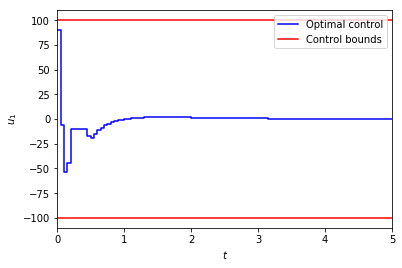

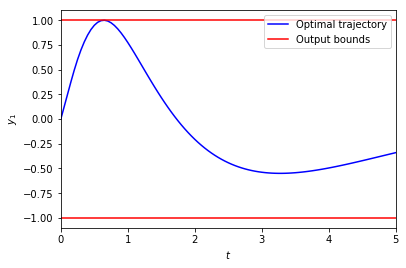

In [8]:
# input
plot_input_sequence(u, h, (u_min, u_max))
plt.show()

# output (horizontal position of the tip of the pole)
C = np.array([[1., -l, 0., 0.]])
y_min = np.array([[-d]])
y_max = np.array([[d]])
plot_output_trajectory(C, x, h, (y_min, y_max))
plt.show()

## Animate results with MeshCat

Now we animate the closed-loop trajectory of the cart-pole with MeshCat (see https://github.com/rdeits/meshcat-python)

In [9]:
import time
import meshcat
import meshcat.geometry as g
import meshcat.transformations as tf

Create a new visualizer

In [10]:
vis = meshcat.Visualizer()
vis.open()

You can open the visualizer by visiting the following URL:
http://127.0.0.1:7000/static/


<Visualizer using: <meshcat.visualizer.ViewerWindow instance at 0x10e11ef80> at path: ['meshcat']>

Create the cart-pole

In [11]:
# cart-pole
cart_pole = vis["cart_pole"]

# cart
cart = cart_pole["cart"]
cart.set_object(g.Box([.3*l, .3*l, .3*l]))

# pivot
pivot = cart["pivot"]
pivot.set_transform(tf.rotation_matrix(np.pi/2, [1, 0., 0.]))

# pole
pole = pivot["pole"]
pole.set_object(g.Box([.05*l, l, .05*l]))
pole.set_transform(tf.translation_matrix([0., .5, 0.]))

# left wall
left_wall = vis["left_wall"]
left_wall.set_object(g.Box([l, .05*l, l]))
left_wall.set_transform(tf.translation_matrix([0., -d, l]))

# right wall
right_wall = vis["right_wall"]
right_wall.set_object(g.Box([l, .05*l, l]))
right_wall.set_transform(tf.translation_matrix([0., d, l]))

Animate the results

In [12]:
# visualization function
def visualize_cart_pole(x):
    cart.set_transform(tf.translation_matrix([0, x[0,0], 0]))
    pivot.set_transform(tf.rotation_matrix(x[1,0] + np.pi/2, [1, 0, 0]))

# animation
for t in range(Nsim):
    visualize_cart_pole(x[t])
    time.sleep(h)